# <span>Capstone Part 03</span>
*Text analytics and Modelling on Aviation Accident Analysis*
## Submitted by - Roshan Lulu



****
> ![Narrative Analytics](../part03/assets/text_analytics.jpg)

## Introduction
- In this Notebook I will be analyzing the accident summary in the dataset.
- Along with analysing the patterns in accidents based on different features, it would be interesting to classify the incidents based on the narrative.

## A. Import Dataset
- The raw dataset was from aviation.net was cleaned during the data munging and exploratory data analysis phase. 
- I will be reading in the cleaned version of the dataset here to have a look at the **Narrative** feature

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale=1.5)

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
path = './dataset/01_aviation_cleaned.csv'

In [3]:
data = pd.read_csv(path)

In [4]:
data.Nature_Code.unique()

array(['Military', 'Cargo', 'Unknown', 'Passenger - Domestic',
       'Ferry/positioning', 'Train/Test/Demo', 'Passenger - Intl',
       'Private', 'Executive', 'Illegal Flight', 'Agricultural',
       'Ambulance', 'Fire fighting'], dtype=object)

In [5]:
data = data[(data['Nature_Code'] == 'Passenger - Domestic') | (data['Nature_Code'] == 'Passenger - Intl')]

In [6]:
data.head(2)

,Engines,Narrative,FlightNumber,InvestigatingAgency,Status,Nature,AirplaneDamage,Phase,DestinationAirport,Date,Time,DepartureAirport,Operator,DurationOfInvestigation,AirplaneFate,FirstFlight,Nature_Code,Type_Code,Engine_Type,Engine_count,Crew_Fatal,Crew_Occ,Total_Fatal,Total_Occ,Psngr_Fatal,Psngr_Occ,GndFatal,Coll_Fatal,Crash_Elev_m,Day,Month,Year,Dep_Airport_1,Dest_Airport_1,SubLocation,Country,Age,Location_latlon
5,-,"Crashed into a wooded mountainside, killing al...",5,NaN,NaN,Domestic Scheduled Passenger,Damaged beyond repair,En route (ENR),", ItalyRoma (unknown airport)",10,NaN,", ItalyBrindisi-Papola Casale Airport (BDS/LIBR)",Ala Littoria,NaN,NaN,0,Passenger - Domestic,Others,Unknown,-1.0,0,0,10,10,0,0,0,0,0,Saturday,February,1940,BDS,unknown airport,Aiello Calabro,Italy,0,"(41.87194, 12.56738)"
12,-,A Beech 1900D aircraft operated by North-Wrigh...,12,NaN,Preliminary - official,Domestic Scheduled Passenger,Minor,Taxi (TXI),", CanadaTulita Airport, NT (ZFN/CZFN)",9,16:11 UTC,", CanadaNorman Wells Airport, NT (YVQ/CYVQ)",North-Wright Airways,NaN,Repaired,1994,Passenger - Domestic,Beechcraft,Unknown,-1.0,0,2,0,6,0,4,0,0,0,Thursday,February,2017,YVQ,ZFN,"Tulita Airport, NTZFN)",Canada,23,"(56.130366, -106.346771)"


## Natural Language Processing

## B. Text Pre-Processing - Noise Removal

** Text is one of the most unstructured forms of data and Noise removal is a very important step before any data can be analysed. So is the case for text.**

**Noise is information that either corrupts your data or is not useful. Below are some of the common forms of noise in text and that I will be employing going ahead:**

**1. Stop words are the most commonly used words in a language. i.e the words that do not convey meaniful information if on its own. eg: The, A, An, Is, for etc**


**2. Punctuations also do not convey any information from an analytics point of view. Hence, it can also be considered as Noise.**

#### <span style='color:#990000'>Noise(text) = Stopwords(text language) + Punctuation(text)</span>

In [7]:
# Import library 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models, matutils
from collections import defaultdict
import string
from nltk import word_tokenize 
import pycountry

**This is a live stop word listt that I will be iteratively updating. It is a challenge when dealing with unstructured text.**

My list will consist of:
- English stop words
- Country name stop words
- Common aviation terms like airplane, airline etc

In [8]:
# Creating stop words database for all the numbers
stop = stopwords.words('english')
stop += ['00', '000', '01', '02', '03', '04', '04r', '05', '050', '05l', '05r', '06', '06r', '07', '08', '080', '09', '09r', '10', '100', '1000', '10000', '102', '103', '104', '1049', '105', '106', '107', '108', '109', '10deg', '10l', '11', '110', '1100', '111', '111f', '112', '113', '114', '115', '116', '117', '118', '118a', '119', '11f', '11s', '12', '120', '1200', '12000', '121', '361', '376','122', '123', '124', '124c', '125', '128', '129', '12bk', '13', '130', '1300', '130b', '130e', '130h', '130j', '131', '133', '134', '135', '135a', '139', '13l', '14', '140', '1400', '141', '1420', '145', '14500', '146', '148', '15', '150', '1500', '153', '154', '157', '158', '159', '15deg', '16', '160', '1600', '163', '165', '166', '168', '16r', '17', '170', '1700', '172', '175', '1750', '17l', '18', '180', '1800', '180deg', '185', '188', '19', '190', '1900', '1900c', '1900d', '191', '1936', '1938', '1940', '1941', '1942', '1943', '1944', '1945', '1948', '1949', '1950', '1951', '1953', '1954', '1955', '1957', '1963', '1964', '1966', '1968', '1969', '1972', '1973', '1974', '1978', '1979', '1980', '1981', '1982', '1983', '1985', '1986', '1988', '1990', '1991', '1992', '1993', '1994', '1997', '1998', '1999', '19r', '1a', '1a10', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '200c', '201', '2011', '2013', '2015', '202', '203', '2050', '207', '208', '208b', '20deg', '21', '210', '211', '212', '215', '22', '220', '2200', '222', '225', '227', '228', '22l', '23', '230', '2300', '232', '235', '24', '240', '2400', '241', '242', '24b', '24l', '24r', '24rv', '25', '250', '2500', '25l', '26', '260', '265', '266', '26b', '26l', '27', '270', '2700', '27l', '27r', '28', '280', '2800', '285', '28l', '28r', '29', '290', '29l', '2a', '2r', '2t', '30', '300', '3000', '304', '306', '30deg', '31', '310', '31242', '31243', '314', '315', '31l', '31r', '32', '320', '3200', '320o', '322', '325', '328', '32l', '32r', '33', '330', '3300', '330o', '336', '338', '33l', '34', '340', '340b', '340o', '345', '35', '350', '3500', '350o', '35a', '35l', '36', '360', '3600', '37', '38', '39', '390', '3a', '3c', '3deg', '3m', '3mge', '3t', '40', '400', '4000', '41', '410', '410uvp', '42', '420', '4200', '43', '430', '436', '44', '440', '45', '450', '4500', '45deg', '46', '46d', '47', '470', '4700', '47a', '47b', '47d', '47s', '48', '49', '50', '500', '5000', '501', '504', '50832', '50deg', '51', '52', '525', '53', '54', '5400', '55', '550', '5500', '56', '57', '58', '580', '59', '5a', '5h', '5n', '5nm', '5y', '60', '600', '6000', '601', '61', '610', '62', '620', '63', '631', '64', '640', '65', '650', '6500', '66', '67', '68', '6a', '6e', '70', '700', '7000', '707', '71', '710', '72', '720', '725', '727', '73', '737', '74', '747', '748', '75', '750', '7500', '756', '757', '76', '767', '767s', '76md', '770', '777', '78', '78505', '7nm', '80', '800', '8000', '801', '81', '811', '812', '82', '8235', '8241', '82a', '83', '84', '85', '850', '8500', '86', '87', '88', '8807', '89', '8q', '8th', '90', '900', '9000', '90deg', '91', '910', '92', '93', '931', '94', '95', '96', '97', '98', '99', '990', '9k', '9n', '9q', 'a100', 'a300', 'a310', 'a319', 'a320', 'a321', 'a330', 'a6m2', 'aa', 'aaa', 'aab', 'aaf', 'ab', 'ababa']
stop += ['08r', '1009', '101', '1011', '104b', '144', '21st', '221', '22285', '231', '23l', '300yds', '301', '3100', '318', '319', '31de', '321', '321b', '324', '3277', '33666', '33r', '380', '3800', '395', '39a', '3mce', '400a', '402q', '40563', '40deg', '415', '42e', '42w', '4300', '451', '460', '701', '702', '712', '730', '740', '75a', '76td', '7700', '775', '780', '78270', '78462', '785', '797', '800xp', '823', '841', '8as', '8r', '901', '919', '920', '926', '980', '9j', '9l', '9m']
stop += ['675','680','6800','6b', '000ft']
stop += ['airport', 'airplane','aircraft', 'approach',
 'crashed','crew','feet','flight','following','main','members','near','one','operated','passenger','passengers','plane','runway','struck','substantial','sustained','three','took','two','boeing','dc','due','beyond',
 'damaged','b200','repair', 'miles', 'km', 'air', 'lines', 'departed', 'abort', 'takeoff', 'landing', 'reported', 'airline', 'captain'
 ]
stop += ['001', '0014', '002', '003', '006', '010', '010º', '0127', '015', '017', '0171', '0173', '0195', '01l', '01r', '020', '020deg', '0218', '022', '024', '0256', '02801', '02r', '030', '030º', '0326', '0328', '040', '040b', '040deg', '044', '045', '0450', '0462', '0463', '049', '04l', '053', '0597', '060', '0602', '060deg', '061', '064', '069', '06l', '070', '0703', '0705', '0719', '072', '0730', '07308', '075deg', '076', '07l', '07r', '0839', '085', '0850', '08l', '090', '0900', '090deg', '092', '094', '0970', '0972', '0981', '09l', '1002', '1006', '1007', '1008', '100912', '100deg', '100e', '100er', '100nm', '100yds', '10100', '1015', '1018', '1020', '10200', '1024', '1025', '1027', '10350', '1036', '1040', '1041k', '104g', '1050', '10500', '1054', '10554', '1058', '1060', '10687', '1069', '1070', '10737', '1074', '1075', '1081', '1086', '10884', '10942', '109770', '10a', '10f', '10nm', '11000', '110c', '110p1', '1114', '1120', '11200', '1121', '1123', '1124', '1124a', '1132', '1140', '11500', '1154', '1159', '11600', '11620', '1169', '1170', '1171', '1173', '117d', '11800', '11900', '1198', '119b', '119c', '119cf', '119f', '119k', '11a', '11deg', '11dme', '1200yds', '120er', '1212', '1215', '121d', '121g', '121k', '121m', '122443', '1229', '1230', '12328', '12364', '123k', '12435', '12467', '124a', '1250', '12500', '1255', '125kts', '126', '1260', '12600', '127', '1276', '1277', '127723', '1279', '1281', '1296', '12a', '12b', '12bp', '12deg', '12l', '12n', '12p', '12th', '12w', '13000', '1300k', '1301', '1307', '130a', '130f', '130kias', '130m', '130p', '130r', '1310', '131582', '131639', '131e', '131f', '132', '1320', '13200', '1322', '1325gal', '1329', '1338', '133b', '133deg', '1340', '13400', '1342', '1347', '134a', '134ak', '13500', '135350', '1355', '135deg', '135j', '135kl', '135lr', '135n', '135r', '135s', '135t', '135v', '136', '1360', '137', '1370', '137e', '138', '13807', '1390', '13e', '13r', '14000', '1400z', '140a', '141b', '142', '143', '1436', '1440', '1449', '144a', '1450', '1455', '1457', '145kts', '145li', '145lr', '145lu', '146deg', '147', '1486', '149', '1490', '1493', '1495', '14970', '149813', '149d', '14b', '14fkm', '14p', '14th', '15000', '1500yds', '1500z', '1502', '1509', '150deg', '150f', '150ft', '150h', '150m', '151', '151890', '152', '15200', '152608', '1533', '1535', '1539', '1541', '1545', '1549', '154a', '154b', '154m', '155', '1550', '155130', '1553', '15585', '155deg', '156', '15652', '15677', '1568', '1570', '15721', '157332', '15800', '158761', '1588', '158930', '159325', '15f', '15l', '15r', '15s', '15th', '15tm', '16000', '1602', '160r', '161', '1610', '16100', '162', '164', '1640', '1645', '16481', '1649a', '16500', '165522', '165525', '1669', '167', '16720', '1687', '1690', '16a', '16b', '16d', '16f', '16l', '16th', '17000', '17010', '1707', '1709', '1716', '171st', '1720', '1721', '1723', '172n', '173', '1730', '1733', '1736', '17388', '174', '1763', '1768', '178', '178deg', '179', '1790', '17c', '17f', '17g', '17r', '17th', '18000', '1801', '181', '1810', '1814', '182', '18255', '1828', '182l', '1833', '1840', '18440', '1850', '1851', '18591', '18598', '186', '1860', '187', '1870', '1880', '1885', '189', '18930l', '18a', '18b', '18d', '18r', '18th', '18v', '19000', '1902', '1908', '1909', '190deg', '1910', '1918', '192', '1920', '1921', '1922p', '1923', '1925', '1929', '193', '1930', '1933', '1934', '1935', '1937', '1939', '194', '1946', '1947', '195', '1952', '1956', '1958', '1959', '1960', '1961', '1962', '1967', '197', '1970', '1971', '1975', '1976', '1977', '198', '1984', '1987', '1989', '1990s', '1995', '1996', '199deg', '19a', '19l', '1b', '1g167', '1h', '1h18', '1hour', '1l', '1r', '20000', '2000ft', '2008', '2009', '200b', '200deg', '200er', '200ft', '200x100', '200yds', '2010', '2012', '2014', '2016', '2025', '204', '204b', '205', '206', '206b', '2086', '209b', '20c', '20f', '20gmt', '20l', '20r', '20th', '2100', '2104', '2110', '212667', '212a', '213', '214', '21504', '216', '2165', '218', '21b', '21l', '21mf', '21r', '21u', '2200m', '220º', '2215', '2219', '221f', '2230', '224', '2250rpm', '226', '227ac', '227b', '227bc', '2280', '2284', '2286', '229', '2295', '22c', '22r', '2300yds', '2303', '2311', '2318', '233', '23310', '23488', '2350', '235m', '236', '2370', '238', '238b', '23f', '23r', '24000', '2400rpm', '2406', '240deg', '2422x', '243', '245', '2450', '246', '2460', '246er', '246tg', '247', '247d', '248', '2487', '24a', '24bi', '24kay', '24ko', '24th', '25000', '2501f', '250deg', '250yds', '250º', '251', '2523', '255', '2560', '258', '25b', '25d', '25deg', '25g', '25nm', '25pd', '25r', '25th', '2600', '2600rpm', '260deg', '261', '2615', '2620', '263', '2638', '26492', '2650', '2652', '26r', '27097', '270deg', '271', '2710', '2720', '2733', '2734', '274', '2740', '2747', '275', '2750', '277', '2771', '2790', '27deg', '27th', '280c', '280º', '2813', '2823', '283er', '284', '2841', '2850', '2850rpm', '286', '287', '2873', '288', '2885', '28d', '28nm', '28p', '28th', '2900', '291', '2925', '295m', '296', '297', '298', '29nm', '29r', '2a8', '2b', '2deg', '2e', '2f', '2h', '2nd', '2nm', '2p', '2sq', '2t5', '2tp', '2u3b', '3002', '300er', '300s', '300º', '302ftu', '303', '3050', '3068', '306m', '307', '3079', '307b', '308', '30862', '30a', '30b', '30cf', '30f', '30l', '30psi', '30r', '30th', '3102', '3108', '310deg', '310º', '311', '311q', '312', '3120', '3130', '3132', '3137', '3150', '317', '3183', '31fi', '3205', '320º', '3232', '3233', '3244lb', '3252', '3260', '3263', '3281', '328jet', '329c', '32a', '32tons', '32z', '330yds', '330º', '331', '3316', '334', '335', '3380', '339', '33a', '33rc', '3400', '34037', '340a', '340er', '340º', '3416', '342', '343', '343rd', '344', '344c', '3476', '34deg', '34l', '34r', '3506', '350º', '352nd', '353', '354', '3540', '355', '357', '3587', '35deg', '35r', '360deg', '3628', '365', '366', '3666', '366er', '3679', '3680', '368lb', '369', '3698', '36a', '36l', '36n', '36r', '370', '3700', '3700rpm', '371', '3720', '375', '377', '378', '379c', '379th', '381er', '3839x', '384th', '385', '38658', '38667', '387', '389', '38th', '3900', '392', '3930', '39323', '39325', '3960', '398', '39939', '39980', '39n', '3b', '3b4c', '3h4', '3k1c', '3l', '3mfe', '3mg4e', '3mlu', '3mte', '3nm', '3rd', '400b', '400bcf', '400yds', '402', '403', '40312', '404', '4042', '405', '406', '4064', '40641', '4069', '407', '408', '40a', '40cm', '40gmt', '40in', '40k', '40nm', '40s2', '40z', '4100', '411', '412f', '413th', '4146', '418', '41834', '419', '4192', '41deg', '41st', '4204', '422', '42444', '425', '4250', '4265', '42a', '42b', '431', '4317', '4340', '435', '4350', '436th', '4374', '439', '43b', '43s', '4400', '441', '44166', '4422', '444', '4458', '44648', '4479', '4525', '4536', '4539', '455', '457', '45g', '4600', '462', '46327', '465', '467', '46807', '46deg', '46e', '46f', '471', '4723', '47302', '47360', '474', '475', '4750', '477', '47deg', '47e', '47j', '47nm', '47p', '47q', '480', '4805', '481', '484', '4860', '4896', '490', '4900', '4904', '491', '4915', '492', '495', '496', '499', '4a', '4c', '4f', '4g', '4h6', '4k', '4l', '4nm', '4y0', '500ft', '500m', '500sq', '500yds', '501sp', '502', '5049', '505', '506', '507', '508', '509', '50c', '50feet', '50psi', '50s', '50th', '510', '5100', '512', '5120', '5160', '518', '520', '52002', '524', '5250', '525c', '527', '529', '52g', '530', '5300', '530yds', '5315', '5323', '5340', '537', '53d', '540', '5401', '5407', '541', '542ct', '543', '545', '5452', '546', '54a', '54b', '550b', '5513', '553', '5539', '557', '558', '55deg', '55kts', '55th', '560', '5600', '560xl', '561', '5615', '5669', '5675', '56g', '56pst', '56th', '570', '5700', '5711', '572', '5733', '57752', '57760', '5800', '580a', '580as', '5811', '583', '585', '588', '589', '590', '5900', '592', '594', '595', '599', '59d', '5b', '5d', '5deg', '5e', '5f', '5g', '5th', '5v', '5x', '5x61', '600f', '600gal', '600r', '600yds', '6013', '6017', '601e', '602', '603', '60314', '603m', '603sq', '604', '6048', '6050', '605r', '6060', '60deg', '6100', '611', '614', '6150', '6163', '6165', '61708', '618', '621', '623', '6240', '625', '6250', '626', '627', '628', '6289', '6291', '62f', '630', '6300', '634', '6343', '635', '6350', '6354', '63f', '6400', '642', '6420', '643', '6448', '64w', '6500ft', '65120', '652', '6526', '654', '655', '65691', '658', '65856', '65nm', '661', '663', '6631', '664', '666', '6700', '670a', '671', '6715', '6745', '676', '67608', '6780', '6800ft', '681', '6865', '687', '6878', '6901', '696', '69620', '6970', '6bf', '6deg', '6in', '6nm', '6th', '70000', '700a', '700b', '70349', '704', '705', '706', '708', '70yds', '7100', '711', '714', '716', '717', '718', '7200', '721', '7218', '724', '726', '72614', '731', '732', '7353', '736', '738', '739', '73960', '7400', '742', '7463', '747sp', '749', '7493', '751', '752', '753', '7533', '75687', '75732', '760', '7613', '7638', '765', '76679', '76685', '76761', '7682', '76825', '76827', '76t', '77', '771', '772', '773', '7743', '77508', '7775', '7800', '7800ft', '7815', '7816', '783', '783cp', '7843', '785d', '7864', '78826', '78849', '79', '790', '793', '7980', '7989', '7b', '7c', '7deg', '7m', '7occupants', '7½', '8000f', '800b', '800ft', '8012', '8015', '8019', '802', '805', '8050', '806', '809', '80c2b2', '80deg', '81000', '813', '8137', '813th', '814', '817', '819', '820', '821', '824', '8276', '82s', '8300', '831', '8315', '832', '835', '8355', '837', '839', '840', '8400', '843', '844', '84738', '84g', '8502', '850xp', '851', '8535', '855', '860', '8600', '861', '8650', '8665', '86a', '86b', '86d', '870', '8700', '8738', '875', '878', '87s', '881', '8810', '88241', '885', '886', '8867', '890', '897', '89d', '8c', '8f600', '8g', '8h4', '8nm', '900c', '9018', '901a', '902', '904', '906', '90nm', '90º', '9100', '911', '914', '916', '918', '9202', '921', '922', '9243', '927', '930', '9300', '933', '9350', '936', '940', '941', '942', '946', '94b', '950', '9500'
         , '953', '95981', '95b', '960', '962633', '9640', '967', '96th', '970', '9700', '975', '9766', '97g', '9800', '983', '984', '9842', '985', '9859', '9877', '9900', '99165', '9925', '9930', '9955', '9975', '99853', '99a', '99c', '9d', '9k38', '9th', '9v', '9w354', 'a1', 'a12', 'a185f', 'a2', 'a23', 'a300b4', 'a31', 'a340', 'a36', 'a4', 'a400m', 'a59', 'a59w', 'a6', 'a65', 'a6m', 'a7', 'aa201', 'aa320', 'aa423', 'aa699', 'aac', 'aam', 'aapo', 'aar', 'aarhus', 'aau']

In [9]:
# Add all countries as stop words
for c in list(pycountry.countries):
    stop.append(c.name.lower())

## C. Text PreProcessing
### Text Normalisation

**Normalisation of data is converting different forms of the same word into a common one. Two of the commonly used forms are :**

** 1. Stemming i.e. stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.**
- I tried using Stemming for my text, but it stripped the word of all its meaning, hence currently I am not using stemming. 


** 2. Lemmatization i.e. an organised and step by step procedure of obtaining the root form of the word, it makes use of vocabulary and word structure and grammar relations.**
- Lemmatization, did not help me much. For now, I am not using these functions. But at a later point I will come back to it if required.

In [10]:
stemmer = PorterStemmer()

In [11]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    print(stems)
    return stems

## D. Feature Extraction
### Count Vectorizer: to get the most commonly used vocabulary

** Count vectorizer is one of the basic techniques when dealing with textual content. It is the process of getting a word count of the text/document. The parameters of a count vectorizer can be modified depending on the problem at hand.**

*As an initial step, I will be analyzing the word count from all the aviation accident summaries*
- There are 14836 distinct words excluding the stop words.

In [12]:
# vectorizer = CountVectorizer(analyzer = "word",tokenizer = None, lowercase=True, strip_accents="unicode",
#                              preprocessor = None,stop_words = stop,max_features = 1000, ngram_range = (1,1)) 

vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = stop, ngram_range = (2,2)) 
X_narrative = vectorizer.fit_transform(data['Narrative'])

X_narrative.shape

vocabulary = vectorizer.vocabulary_
vocabulary

# Get count of tokens
docs = pd.DataFrame(X_narrative.todense(), columns=vectorizer.get_feature_names())
docs.sum()


abandon attempt           0.087175
abandon backtracked       0.087175
abandon called            0.202668
abandon ice               0.318913
abandoned carried         0.214582
abandoned crossed         0.168559
abandoned drifting        0.154409
abandoned heavy           0.252532
abandoned intermittent    0.158317
abandoned jamming         0.309578
abandoned low             0.183736
abandoned pilots          0.156792
abandoned reduced         0.235966
abandoned rolled          0.191834
abandoned second          0.217616
abandoned v1              0.342005
abatement power           0.073661
abatement procedures      0.103697
abbas bnd                 0.404225
abbas four                0.206687
abbeville cleared         0.085214
abdomen polish            0.197637
abdulaziz med             0.621930
abeam barreiras           0.143016
abeam bogotá              0.119035
                            ...   
zone warned               0.141188
zones came                0.140255
zorg en             

In [13]:
# Set up the vocabulary dictionary
vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocab

# Create a token to id mapping with gensims corpora dictionary

frequency = defaultdict(int)

for text in data['Narrative']:
    for token in text.split():
        frequency[token] += 1
        
# Remove words that appear les sno of times
texts = [[token for token in text.split() if frequency[token] > 1 and token not in stop] for text in data['Narrative']]

texts

# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)
texts

# Create corpus matrix
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 5),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 4),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(0, 1), (61, 1), (62, 1), (63, 1)],
 [(14, 1), (64, 1), (65, 1), (66, 1), (67, 1)],
 [(68, 1)],
 [(14, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1)],
 [(5, 1),
  (14, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86

In [14]:
X_narrative

<2701x42969 sparse matrix of type '<class 'numpy.float64'>'
	with 59856 stored elements in Compressed Sparse Row format>

In [15]:
vocab

{42516: 'wooded mountainside',
 25833: 'mountainside killing',
 21386: 'killing people',
 28769: 'people aboard',
 4471: 'beech north',
 26865: 'north wright',
 42655: 'wright airways',
 1428: 'airways conducting',
 8408: 'conducting nwl125',
 27171: 'nwl125 norman',
 26814: 'norman wells',
 41847: 'wells tulita',
 39816: 'tulita trying',
 39758: 'trying initiate',
 20006: 'initiate right',
 32697: 'right hand',
 17623: 'hand turn',
 39993: 'turn ramp',
 31107: 'ramp park',
 28418: 'park manoeuvre',
 24402: 'manoeuvre felt',
 14266: 'felt started',
 36478: 'started slip',
 35554: 'slip slippery',
 35559: 'slippery surface',
 37474: 'surface tried',
 39628: 'tried recovery',
 31506: 'recovery manoeuvre',
 24398: 'manoeuvre applying',
 2455: 'applying differential',
 11246: 'differential power',
 30037: 'power reverse',
 32551: 'reverse braking',
 5344: 'braking however',
 18955: 'however manoeuvres',
 24415: 'manoeuvres unsuccessful',
 40395: 'unsuccessful left',
 22748: 'left wing',
 4

In [16]:
lda = models.LdaModel(
    matutils.Sparse2Corpus(X_narrative, documents_columns=False),
    num_topics  =  3,
    passes      =  100,
    id2word     =  vocab
)

In [17]:
lda.print_topics(num_topics=3, num_words=20)

[(0,
  '0.000*"en route" + 0.000*"caught fire" + 0.000*"engine fire" + 0.000*"came rest" + 0.000*"bad weather" + 0.000*"new york" + 0.000*"left wing" + 0.000*"weather conditions" + 0.000*"la paz" + 0.000*"impacted mountainside" + 0.000*"gear collapsed" + 0.000*"hong kong" + 0.000*"right hand" + 0.000*"los angeles" + 0.000*"destroyed impacted" + 0.000*"engine problems" + 0.000*"coming rest" + 0.000*"minutes later" + 0.000*"route stops" + 0.000*"co pilot"'),
 (1,
  '0.001*"caught fire" + 0.000*"engine failure" + 0.000*"came rest" + 0.000*"junkers ju" + 0.000*"en route" + 0.000*"excursion accident" + 0.000*"ju named" + 0.000*"destroyed accident" + 0.000*"icing conditions" + 0.000*"engine failed" + 0.000*"de havilland" + 0.000*"poor visibility" + 0.000*"twin otter" + 0.000*"go around" + 0.000*"left wing" + 0.000*"first officer" + 0.000*"last radio" + 0.000*"undercarriage collapsed" + 0.000*"forced landed" + 0.000*"right gear"'),
 (2,
  '0.002*"duration hijacking" + 0.002*"hijacking less" +

In [18]:
# Label the topics
topics_labels = {
    0: "Engine Failures",
    1: "Pilot Errors",
    2: "Hijack",
}

## E. Unsupervised Topic Modelling using LDA (Latent Dirichlet Allocation)

I am interested to divide the topics based on the cause of accidents. Hence Clustering them based on the description is the next task. There are many approaches for obtaining topics from a text. 
- Latent Dirichlet Allocation is the most popular topic modeling technique and I am planning to try that first.
-  Term Frequency and Inverse Document Frequency and NonNegative Matrix Factorization techniques are the other topic modelling techniques


**Cleaning and Preprocessing**

Cleaning is an important step before any text mining task. Since this has already been done above. we wont be looking at it.

**Preparing Document-Term(DT) Matrix**

All the text documents combined is known as the **corpus**. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the DT matrix.

**Running LDA Model**

Next step is to create an object for LDA model. The dataset does not have enough information to divide it into train and test sets. To begin, I will be using the LDA model to come up with similar words to create topics for the incidents. This can also be seen as feature engineering using the model. I expect to see some interesting results with this model.

** Fitting the lda model for 3 topic. The number of passes have been kept as 100 for better results. 
The features from count vectorizer have been used here**

In [19]:
doc_topics = [lda.get_document_topics(doc) for doc in corpus]

topic_data = []

for document_id, topics in enumerate(doc_topics):
    
    document_topics = []
    
    for topic, probability in topics:
       
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })

topics_df = pd.DataFrame(topic_data)
topics_df.head()

,document_id,probability,topic,topic_id
0,0,0.059187,Engine Failures,0
1,0,0.064389,Pilot Errors,1
2,0,0.876424,Hijack,2
3,1,0.310403,Engine Failures,0
4,1,0.506308,Pilot Errors,1


In [20]:
topic_prob = topics_df[['topic', 'probability', 'document_id']]
topic_prob.head()

,topic,probability,document_id
0,Engine Failures,0.059187,0
1,Pilot Errors,0.064389,0
2,Hijack,0.876424,0
3,Engine Failures,0.310403,1
4,Pilot Errors,0.506308,1


In [21]:
# topic_prob.set_index('topic').T
topic_prob = pd.pivot_table(topic_prob, values='probability', index='document_id', columns='topic')
topic_prob.head()

topic,Engine Failures,Hijack,Pilot Errors
document_id,,,
0,0.059187,0.876424,0.064389
1,0.310403,0.183289,0.506308
2,0.074670,0.845689,0.079641
3,0.433708,0.065517,0.500775
4,0.642082,0.178918,0.179000


In [22]:
topic = []
for index in range(len(topic_prob)):
    topic.append(topic_prob.iloc[index,:].argmax())

In [23]:
topic_prob['topic'] = topic
topic_prob['topic'].value_counts()

Engine Failures    1109
Pilot Errors        900
Hijack              692
Name: topic, dtype: int64

## How are the failures correlated to each other?
- As expected - Not so much!
- Engine failures/Hijack incidents/Pilot failures seem sensible separations to the different causes.

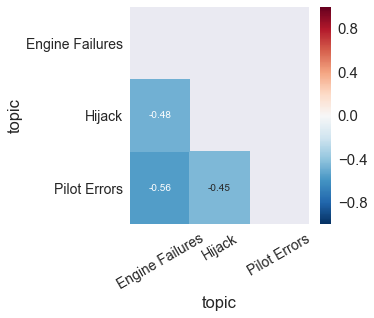

In [24]:
def correlation_heat_map(df):
    corrs = df.corr()
    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(4, 4))
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)
    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()


correlation_heat_map(topic_prob)

## F. Summary

The topic modelling results are quite interesting. The topics were quite well separated and could be used for further analysis.
